In [21]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
env = gym.make('Blackjack-v0')

In [4]:
print(env.__doc__)

Simple blackjack environment

    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.

    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).

    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.

    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.

    The observation of a 3-tuple of: the players c

In [5]:
## The code below shows how to implement GLIE.

def sample_policy(state):
    "Stick at 20, otherwise hit"
    score, dealer_score, usable_ace = state
    return 0 if score >= 20 else 1

def epsilon_greedy_policy(state, Q, eps):
    """
    epsilon = prob to play randomly
    1 - eps = prob to play the action with best Q value = argmax(Q[s][:])
    """
    if np.random.uniform() > epsilon:
        return np.argmax(Q[s][:])
    else:
        number_of_actions = 2
        return np.random.randint(number_of_actions)

def run_episode(env, policy): 
    done = False
    state = env.reset()
    episode = []
    while not done:
        action = policy(state)
        new_state, reward, done, _ = env.step(action)
        episode.append((state,action,reward))
        state = new_state    
    return episode

In [13]:
episode = run_episode(env, sample_policy)
ep_reward = sum(x[2]*(0.9**i) for i, x in enumerate(episode))
print("ep = ", episode)
print("reward =", ep_reward)

ep =  [((14, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
reward = 0.9


### Prediciton problem
 = estimate return of the policy

In [25]:
from collections import defaultdict
from tqdm import tqdm
n_iter = 50000

gamma = 0.9 # discount factor

Q = defaultdict(lambda: np.zeros(env.action_space.n)) # Q function
R = defaultdict(lambda: np.zeros(env.action_space.n)) # Sum of first-visit rewards of a certain (state, action)
N = defaultdict(lambda: np.zeros(env.action_space.n)) # Number of first-visits of a certain (state, action)

for j in tqdm(range(n_iter)):
    episode = run_episode(env,sample_policy) # run till losing
    ep_reward = sum(x[2]*(gamma**i) for i, x in enumerate(episode)) # episode = list of (state,action,reward)
    
    sa_in_episode = set([(tuple(x[0]),x[1]) for x in episode]) # each state is converted to a tuple to use as dict key
    
    # Find first visit of each (state,action) in the episode
    for s,a in sa_in_episode:
        first_visit = next(i for i,x in enumerate(episode) if x[0]==s and x[1]==a)
        
        G = sum(x[2]*(gamma**i) for i, x in enumerate(episode[first_visit:])) # calc reward from this (s,a) till the end of the episode
        R[s][a] += G
        N[s][a] += 1
        Q[s][a] += R[s][a]/N[s][a] # update Q-function

100%|██████████| 50000/50000 [00:04<00:00, 11439.88it/s]


In [22]:
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value

keys = sorted(V.keys())
score = [k[0] for k in keys]
dealer_score = [k[1] for k in keys]
usable = [k[2] for k in keys]
vals = [V[k] for k in keys] 

df = pd.DataFrame({'score':score,'dealer_score':dealer_score,'usable':usable, 'val':vals})

Text(0.5,1,'Usable ace')

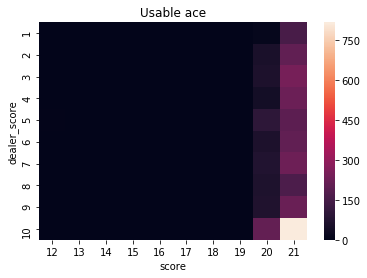

In [23]:
ax = plt.axes()
sns.heatmap(df[df['usable']==True].pivot('dealer_score','score','val'), ax = ax)
ax.set_title("Usable ace")

Text(0.5,1,'Non-usable ace')

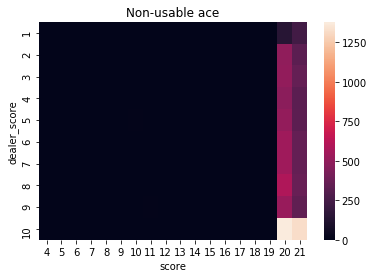

In [24]:
ax = plt.axes()
sns.heatmap(df[df['usable']==False].pivot('dealer_score','score','val'), ax = ax)
ax.set_title("Non-usable ace")

## Your turn:

- Can you modify the code above to implement first-visit Montecarlo with GLIE ("Greedy in the limit with infinite exploration")?
- Plot the value function

### Control problem
 = choose policy giving best returns

First visit $\pi$ -> Q:
1. start with randomly initialized Q function
2. Q function determines the policy => $\epsilon$-greedy strategy
3. $\epsilon$ <- f($\epsilon$), f = decreasing function such as f(x) = $\gamma*x$
    $\epsilon$ = 1 = play randomly
    
    $\epsilon$ = 0.9 = play random action 90% of time, 10% of time choose best action acc to Q function = argmax(Q[s][:]) 
    
Q function = table = with $ \frac{sum of first-visit rewards}{# of first-visits} $ for each (state, action)

After each episode we update the Q function = Q table with quality of states or we can update after a certain number of episodes